
# Pairwise Overlap Benchmark (Bitset vs Inverted Index)

This notebook benchmarks two exact methods for computing pairwise overlaps between sets of features:

1. **Bitset AND + popcount** (tiled; cache-friendly)
2. **Inverted index (SpGEMM-style)**, which adds 1 to a counter for every pair in each feature's posting list

**Inputs**
- `windows`: list of sets of feature IDs (ints in `[0, d)`), one set per window.
- `d`: total number of distinct features.

**Outputs**
- On-disk, upper-triangular memmap of overlap counts (uint16 by default).

> ⚠️ Runtime can grow quickly with `N` and `p`. Start small. You can increase ranges once you've verified the setup.


In [11]:

import os, math, time, gc, shutil, tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 130

# ------------- Overlap storage -------------
class TriangleOverlaps:
    """
    Memory-mapped upper-triangular store for pairwise overlaps.
    - Stores counts for i<j pairs in a 1D memmap of length N*(N-1)//2.
    - Access via obj[i, j] (i != j). Diagonal is implicitly 0.
    """
    def __init__(self, N, dtype=np.uint16, path="overlaps.bin", mode="w+"):
        self.N = int(N)
        self.dtype = np.dtype(dtype)
        self.M = self.N * (self.N - 1) // 2
        self.path = path
        self.mm = np.memmap(self.path, dtype=self.dtype, mode=mode, shape=(self.M,))
        if mode == "w+":
            self.mm[:] = 0

    @staticmethod
    def _tri_index(i, j, N):
        # Vectorized-safe formula for 0 <= i < j < N
        return i * N - (i * (i + 1)) // 2 + (j - i - 1)

    def write_block_assign(self, ii, jj, counts_block):
        a, b = counts_block.shape
        I = np.arange(ii, ii + a, dtype=np.int64)[:, None]
        J = np.arange(jj, jj + b, dtype=np.int64)[None, :]
        mask = I < J
        if not mask.any():
            return
        idx = self._tri_index(I, J, self.N)
        self.mm[idx[mask]] = counts_block[mask].astype(self.dtype, copy=False)

    def add_pairs(self, i_vec, j_vec, val=1):
        i_vec = np.asarray(i_vec, dtype=np.int64)
        j_vec = np.asarray(j_vec, dtype=np.int64)
        m = i_vec < j_vec
        i, j = i_vec[m], j_vec[m]
        if i.size == 0:
            return
        idx = self._tri_index(i, j, self.N)
        np.add.at(self.mm, idx, np.int64(val))

    def __getitem__(self, key):
        i, j = key
        if i == j: return 0
        if i > j:  i, j = j, i
        idx = self._tri_index(np.int64(i), np.int64(j), self.N)
        return int(self.mm[idx])

    def flush(self):
        self.mm.flush()

# 8-bit popcount LUT (for NumPy bitset method)
_POPCNT = np.array([bin(x).count("1") for x in range(256)], dtype=np.uint8)

def _infer_d(windows):
    mx = -1
    for w in windows:
        if len(w):
            mw = max(w)
            if mw > mx: mx = mw
    return mx + 1 if mx >= 0 else 0

from tqdm.auto import tqdm
# ------------- Method 1: bitset + popcount -------------
def overlaps_bitset(windows, d=None, tile=2048, dtype=np.uint16, out_path="overlaps_bitset.bin"):
    """
    Exact overlaps via bitset AND + popcount, tiled to be RAM-light.
    Returns: TriangleOverlaps(memmap on disk).
    """
    N = len(windows)
    if d is None:
        d = _infer_d(windows)
    words = (d + 63) // 64

    # Pack windows -> uint64 bit-matrix [N, words]
    B = np.zeros((N, words), dtype=np.uint64)
    for i, win in enumerate(windows):
        for f in win:
            q, r = divmod(f, 64)
            B[i, q] |= (np.uint64(1) << np.uint64(r))

    tri = TriangleOverlaps(N, dtype=dtype, path=out_path, mode="w+")

    # Tiled pairwise popcount
    for ii in range(0, N, tile):
        A_blk = B[ii:ii + tile]
        for jj in range(ii, N, tile):
            C_blk = B[jj:jj + tile]
            and_words = (A_blk[:, None, :] & C_blk[None, :, :])    # [a,b,W] uint64
            as_bytes = and_words.view(np.uint8).reshape(and_words.shape + (8,))  # [a,b,W,8]
            counts   = _POPCNT[as_bytes].sum(axis=(-1, -2), dtype=np.uint16)     # → [a,b]
            tri.write_block_assign(ii, jj, counts)

    tri.flush()
    return tri

# ------------- Method 2: inverted index -------------
def overlaps_inverted_index(windows, d=None, dtype=np.uint16, out_path="overlaps_invidx.bin"):
    """
    Exact overlaps via inverted index: for each feature, increment all window-pairs containing it.
    Returns: TriangleOverlaps(memmap on disk).
    """
    N = len(windows)
    if d is None:
        d = _infer_d(windows)

    # Build postings: list of arrays of window IDs for each feature
    postings = [[] for _ in range(d)]
    for i, win in enumerate(windows):
        for f in win:
            if 0 <= f < d:
                postings[f].append(i)
    for f in range(d):
        postings[f] = np.asarray(postings[f], dtype=np.int64)

    tri = TriangleOverlaps(N, dtype=dtype, path=out_path, mode="w+")

    # For each feature, add 1 to all pairs within its posting list
    for lst in postings:
        m = lst.size
        if m < 2:
            continue
        r, c = np.triu_indices(m, k=1)
        tri.add_pairs(lst[r], lst[c], val=1)

    tri.flush()
    return tri

# ------------- Data generation -------------
def generate_random_windows(N, d, p, rng=None):
    """
    Generate a list of N sets over features [0, d), each feature independently included with prob p.
    Efficiently samples k~Binomial(d,p) per window, then chooses k unique features.
    """
    if rng is None:
        rng = np.random.default_rng()
    windows = []
    for _ in range(N):
        k = rng.binomial(d, p)
        if k == 0:
            windows.append(set())
        else:
            feats = rng.choice(d, size=k, replace=False)
            windows.append(set(map(int, feats)))
    return windows

# ------------- Timing helper -------------
def time_call(fn, *args, **kwargs):
    t0 = time.perf_counter()
    out = fn(*args, **kwargs)
    t1 = time.perf_counter()
    return out, (t1 - t0)



## Quick sanity check (small problem)

Run both methods on a tiny dataset to verify they produce identical overlaps.


In [12]:

d = 3000
N_test = 100
p_test = 0.01
rng = np.random.default_rng(0)

windows = generate_random_windows(N_test, d, p_test, rng=rng)

workdir = tempfile.mkdtemp(prefix="overlap_bench_")
bitset_path = os.path.join(workdir, "overlaps_bitset.bin")
invidx_path = os.path.join(workdir, "overlaps_invidx.bin")

tri1, t1 = time_call(overlaps_bitset, windows, d=d, tile=512, out_path=bitset_path)
tri2, t2 = time_call(overlaps_inverted_index, windows, d=d, out_path=invidx_path)

print(f"Bitset time: {t1:.3f} s | Inverted-index time: {t2:.3f} s")

# spot-check a few random pairs
pairs = [(0,1),(2,3),(4,5),(10,20),(0,99)]
ok = True
for i,j in pairs:
    if tri1[i,j] != tri2[i,j]:
        ok = False
        print(f"Mismatch at {(i,j)}: {tri1[i,j]} vs {tri2[i,j]}")
print("Methods match on sampled pairs." if ok else "Sampled pairs do not match.")

# cleanup
tri1.flush(); tri2.flush()
del tri1, tri2
gc.collect()
try:
    os.remove(bitset_path)
    os.remove(invidx_path)
    shutil.rmtree(workdir, ignore_errors=True)
except Exception as e:
    print("Cleanup warning:", e)


Bitset time: 0.029 s | Inverted-index time: 0.058 s
Methods match on sampled pairs.



## Parameter sweep configuration

Adjust the ranges below. Start small, then scale up.
- `N_list`: number of windows
- `p_list`: feature probability per window
- `d`: number of distinct features (default 3000)

> The sweep writes a temporary memmap file per run (overwritten each iteration) and cleans it up after timing to avoid disk bloat.


In [39]:

# --- Sweep parameters ---
d = 3000
N_list = [100,1000,2000,3000,4000,5000]                 # scale up cautiously: e.g., [500, 1000, 2000, 5000]
p_list = [0.001, 0.005, 0.01,0.02,0.03,0.04,0.05,0.06,0.07]            # you can extend to up to 0.07
tile    = 1024                           # bitset tile size; increase with RAM
dtype   = np.uint16
do_bitset = True
do_invidx = True

rng = np.random.default_rng(123)

# --- Output collector ---
records = []
workdir = tempfile.mkdtemp(prefix="overlap_bench_sweep_")
bitset_path = os.path.join(workdir, "overlaps_bitset.bin")
invidx_path = os.path.join(workdir, "overlaps_invidx.bin")

print("Temporary workdir:", workdir)


Temporary workdir: C:\Users\miles\AppData\Local\Temp\overlap_bench_sweep_lri5kmv2



## Run the sweep

For each `(N, p)`:
1. Generate randomized `windows`
2. Run **Method 1: Bitset**
3. Run **Method 2: Inverted Index**


In [40]:
# Progress-enabled parameter sweep (replaces the old "Run the sweep" cell)
from tqdm.auto import tqdm
import itertools
import math

records = []
workdir = tempfile.mkdtemp(prefix="overlap_bench_sweep_")
bitset_path = os.path.join(workdir, "overlaps_bitset.bin")
invidx_path = os.path.join(workdir, "overlaps_invidx.bin")

combos = list(itertools.product(p_list, N_list))
steps_per_combo = 1 + int(do_bitset) + int(do_invidx)
t = tqdm(total=len(combos) * steps_per_combo, desc="Total sweep", unit="step")

for p, N in combos:
    # 1) data generation
    windows, t_gen = time_call(generate_random_windows, N, d, p, rng)
    records.append(dict(method="data", step="generate", N=N, p=p, d=d, time_sec=t_gen))
    t.update(1)

    # 2) bitset
    if do_bitset:
        tri1, t_b = time_call(overlaps_bitset, windows, d=d, tile=tile, dtype=dtype, out_path=bitset_path)
        records.append(dict(method="bitset", step="compute", N=N, p=p, d=d, time_sec=t_b))
        tri1.flush()
        del tri1
        gc.collect()
        try:
            os.remove(bitset_path)
        except FileNotFoundError:
            pass
        t.update(1)

    # 3) inverted index
    if do_invidx:
        tri2, t_i = time_call(overlaps_inverted_index, windows, d=d, dtype=dtype, out_path=invidx_path)
        records.append(dict(method="inverted_index", step="compute", N=N, p=p, d=d, time_sec=t_i))
        tri2.flush()
        del tri2
        gc.collect()
        try:
            os.remove(invidx_path)
        except FileNotFoundError:
            pass
        t.update(1)

# cleanup
try:
    shutil.rmtree(workdir, ignore_errors=True)
except Exception as e:
    print("Workdir cleanup warning:", e)

df = pd.DataFrame.from_records(records).sort_values(["method","N","p"]).reset_index(drop=True)
t.close()
print(df.head())


Total sweep:   0%|          | 0/162 [00:00<?, ?step/s]

   method     step    N      p     d  time_sec
0  bitset  compute  100  0.001  3000  0.021077
1  bitset  compute  100  0.005  3000  0.022460
2  bitset  compute  100  0.010  3000  0.022880
3  bitset  compute  100  0.020  3000  0.024106
4  bitset  compute  100  0.030  3000  0.027202



## Results table


In [41]:


out_csv = "overlap_benchmark_results.csv"
df.to_csv(out_csv, index=False)
print(df)
print("Saved CSV:", out_csv)


             method     step     N      p     d   time_sec
0            bitset  compute   100  0.001  3000   0.021077
1            bitset  compute   100  0.005  3000   0.022460
2            bitset  compute   100  0.010  3000   0.022880
3            bitset  compute   100  0.020  3000   0.024106
4            bitset  compute   100  0.030  3000   0.027202
..              ...      ...   ...    ...   ...        ...
157  inverted_index  compute  5000  0.030  3000   4.625769
158  inverted_index  compute  5000  0.040  3000   8.467922
159  inverted_index  compute  5000  0.050  3000  11.815030
160  inverted_index  compute  5000  0.060  3000  22.456175
161  inverted_index  compute  5000  0.070  3000  29.586565

[162 rows x 6 columns]
Saved CSV: overlap_benchmark_results.csv



## Heatmaps (log10 seconds) vs `N` and `p`

One figure per step/method.


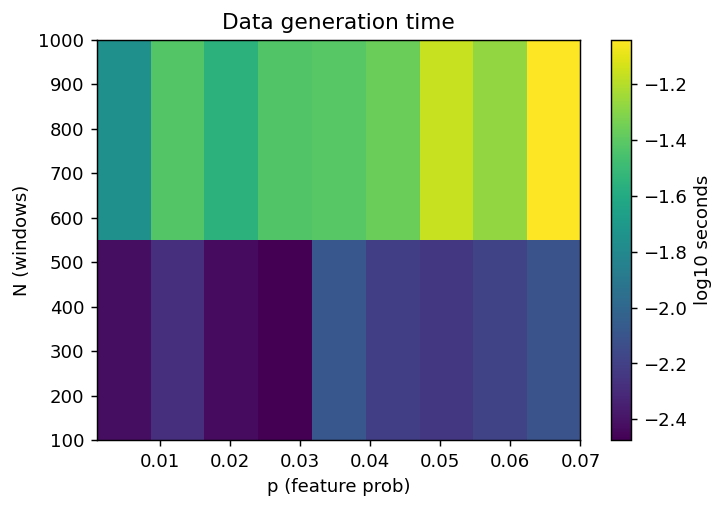

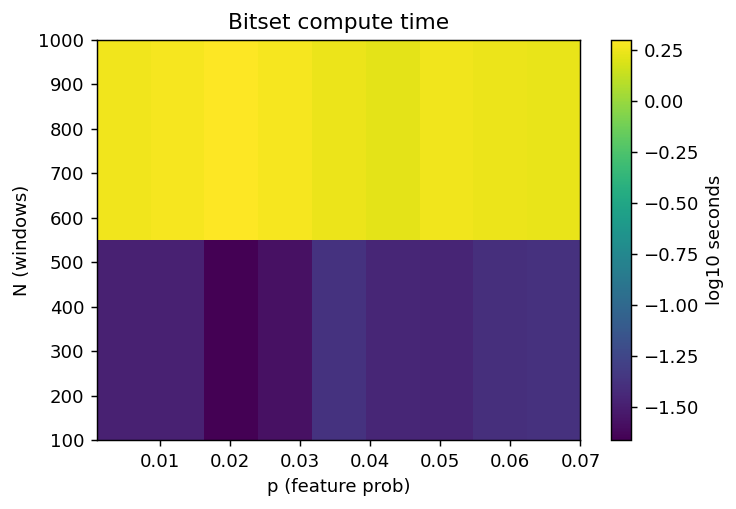

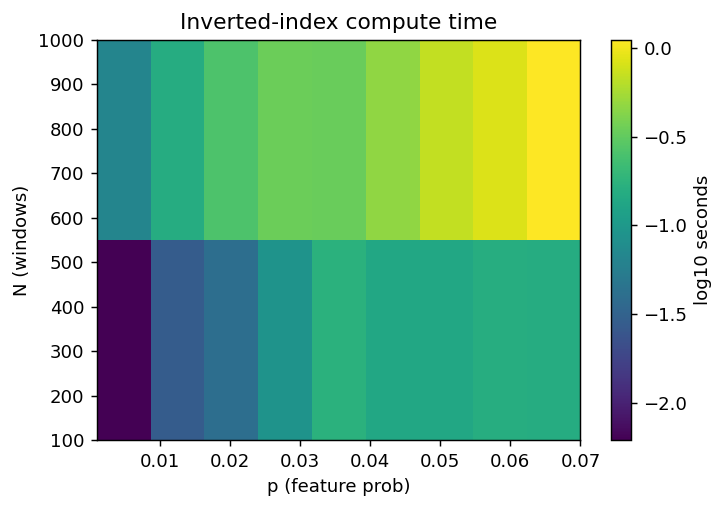

In [33]:

def plot_heatmap(df_sel, title):
    # pivot to matrix with rows=N, cols=p
    mat = df_sel.pivot_table(index="N", columns="p", values="time_sec", aggfunc="mean")
    Z = np.log10(mat.values + 1e-9)
    fig = plt.figure(figsize=(6, 4))
    im = plt.imshow(Z, aspect="auto", origin="lower", interpolation="nearest",
                    extent=[mat.columns.min(), mat.columns.max(), mat.index.min(), mat.index.max()])
    plt.colorbar(im, label="log10 seconds")
    plt.xlabel("p (feature prob)")
    plt.ylabel("N (windows)")
    plt.title(title)
    plt.show()

plot_heatmap(df[df["method"]=="data"], "Data generation time")
if (df["method"]=="bitset").any():
    plot_heatmap(df[df["method"]=="bitset"], "Bitset compute time")
if (df["method"]=="inverted_index").any():
    plot_heatmap(df[df["method"]=="inverted_index"], "Inverted-index compute time")


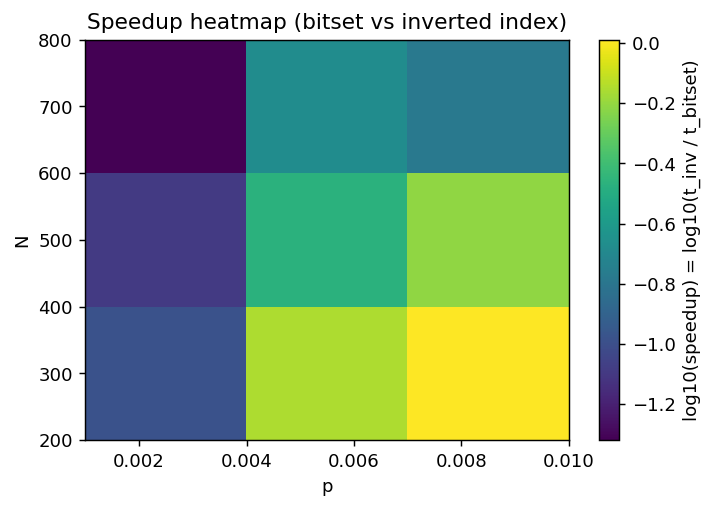

In [18]:
# Speedup = time_invidx / time_bitset  (so <1 favors inverted index)
bitset = df[df["method"]=="bitset"].pivot_table(index="N", columns="p", values="time_sec", aggfunc="mean")
invidx = df[df["method"]=="inverted_index"].pivot_table(index="N", columns="p", values="time_sec", aggfunc="mean")

common_N = np.intersect1d(bitset.index.values, invidx.index.values)
common_p = np.intersect1d(bitset.columns.values, invidx.columns.values)
if common_N.size and common_p.size:
    B = bitset.loc[common_N, common_p].values
    I = invidx.loc[common_N, common_p].values
    S = I / (B + 1e-12)  # >1 => bitset faster

    fig = plt.figure(figsize=(6,4))
    im = plt.imshow(np.log10(S), aspect="auto", origin="lower",
                    extent=[common_p.min(), common_p.max(), common_N.min(), common_N.max()],
                    interpolation="nearest")
    plt.colorbar(im, label="log10(speedup) = log10(t_inv / t_bitset)")
    plt.xlabel("p")
    plt.ylabel("N")
    plt.title("Speedup heatmap (bitset vs inverted index)")
    plt.show()
else:
    print("Not enough common (N,p) points to form a speedup heatmap.")


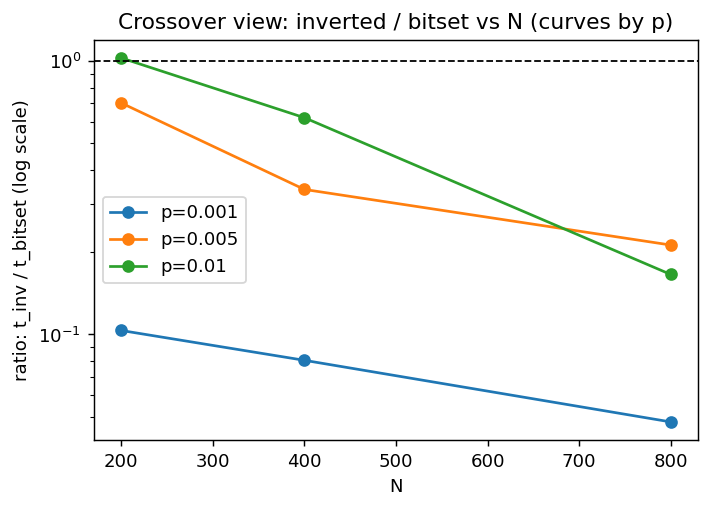

In [19]:
fig = plt.figure(figsize=(6,4))
has_any = False
for p in sorted(common_p):
    b = bitset[p].dropna()
    i = invidx[p].dropna()
    idx = b.index.intersection(i.index)
    if len(idx) == 0:
        continue
    r = (i.loc[idx] / (b.loc[idx] + 1e-12)).sort_index()
    plt.plot(r.index.values, r.values, marker="o", label=f"p={p}")
    has_any = True

if has_any:
    plt.axhline(1.0, color="k", linestyle="--", linewidth=1)
    plt.yscale("log")
    plt.xlabel("N")
    plt.ylabel("ratio: t_inv / t_bitset (log scale)")
    plt.title("Crossover view: inverted / bitset vs N (curves by p)")
    plt.legend()
    plt.show()
else:
    print("No overlapping (N,p) to plot crossover lines.")



## Line plots: time vs N (separate curves for p)


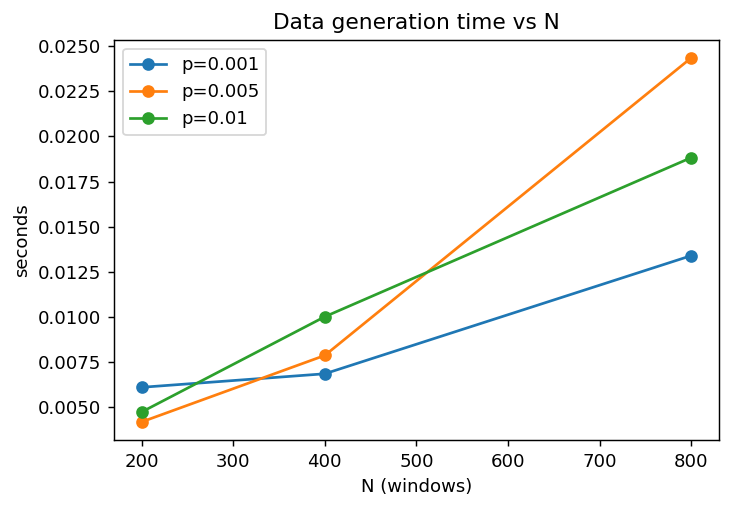

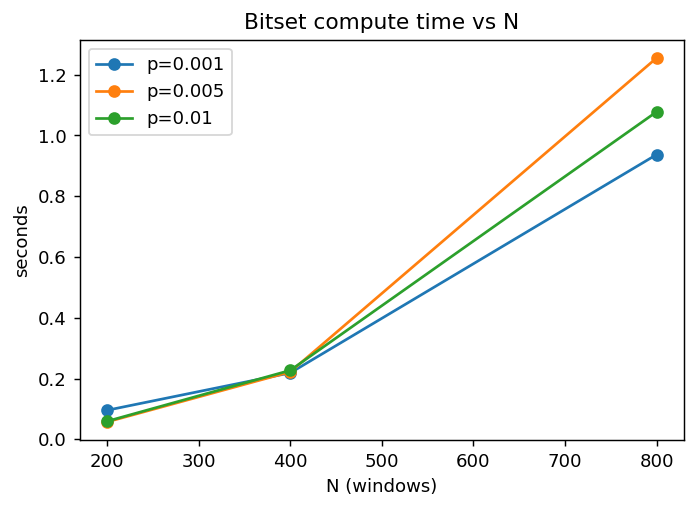

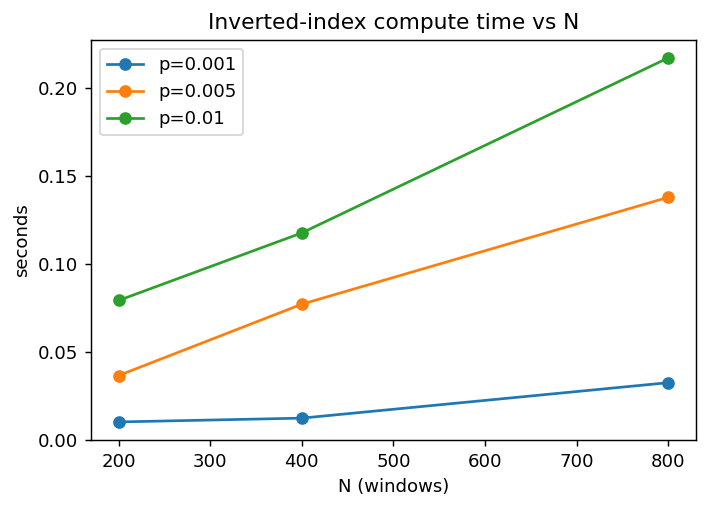

In [10]:

def plot_lines(df_sel, title):
    fig = plt.figure(figsize=(6,4))
    for p, grp in df_sel.groupby("p"):
        grp = grp.sort_values("N")
        plt.plot(grp["N"].values, grp["time_sec"].values, marker="o", label=f"p={p}")
    plt.xlabel("N (windows)")
    plt.ylabel("seconds")
    plt.title(title)
    plt.legend()
    plt.show()

plot_lines(df[df["method"]=="data"], "Data generation time vs N")
if (df["method"]=="bitset").any():
    plot_lines(df[df["method"]=="bitset"], "Bitset compute time vs N")
if (df["method"]=="inverted_index").any():
    plot_lines(df[df["method"]=="inverted_index"], "Inverted-index compute time vs N")



### Notes
- Increase `N_list` and `p_list` gradually; dense regimes (`p≳0.05`) make the inverted index much slower.
- For large runs, consider `dtype=np.uint32` if overlaps can exceed 65535.
- To reduce disk I/O impact on timings, you can direct memmaps to a RAM-disk (if available) or keep `N` modest.
- The generation routine samples `k~Binomial(d,p)` per window and picks `k` unique features — efficient for small `p`.


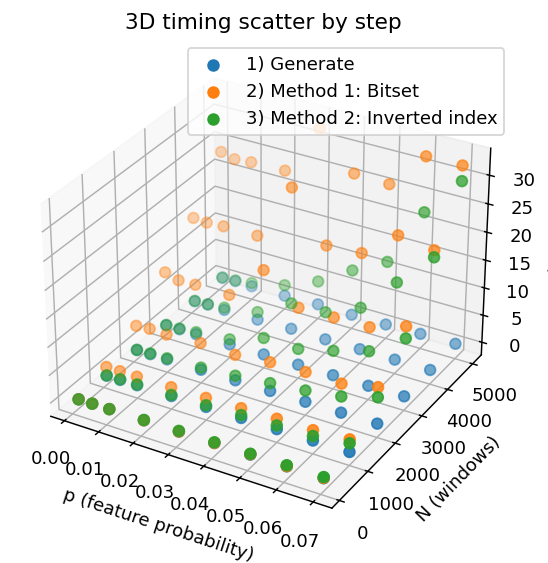

In [42]:
# 3D scatter: X=p, Y=N, Z=time; color by step (data=1, bitset=2, invindex=3)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')

color_map = {
    ("data","generate"):        "tab:green",   # 1
    ("bitset","compute"):       "tab:blue",    # 2
    ("inverted_index","compute"): "tab:red"    # 3
}
label_map = {
    ("data","generate"): "1) Generate",
    ("bitset","compute"): "2) Method 1: Bitset",
    ("inverted_index","compute"): "3) Method 2: Inverted index"
}

for key, color in color_map.items():
    sub = df[(df["method"]==key[0]) & (df["step"]==key[1])]
    if sub.empty: 
        continue
    ax.scatter(sub["p"].values, sub["N"].values, sub["time_sec"].values,
               label=label_map[key], s=35)

ax.set_xlabel("p (feature probability)")
ax.set_ylabel("N (windows)")
ax.set_zlabel("time (s)")
ax.set_title("3D timing scatter by step")
ax.legend()
plt.show()


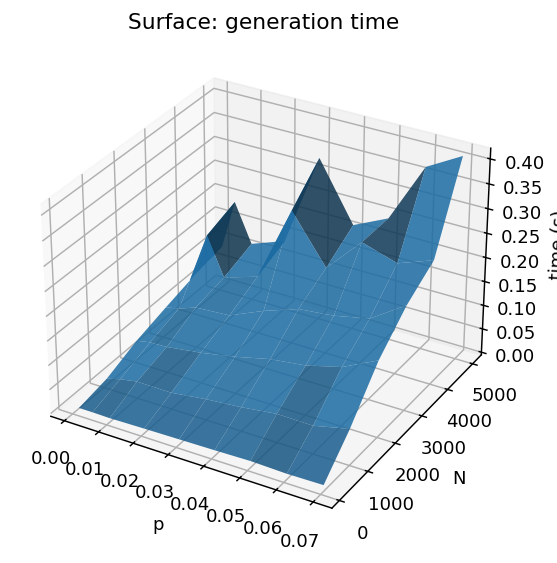

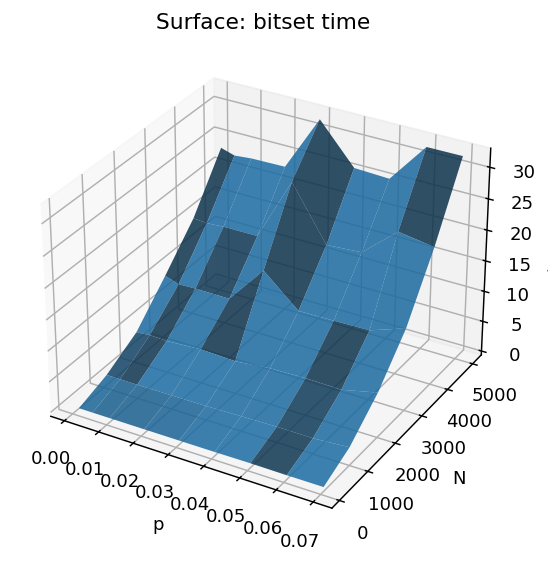

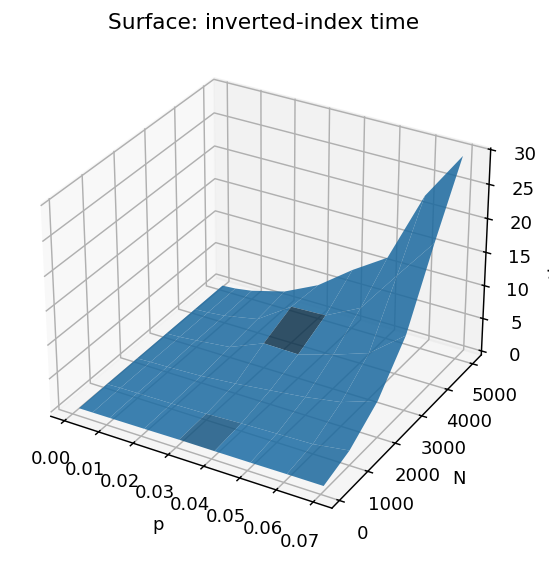

In [43]:
def plot_surface_for(method_name, title):
    sub = df[df["method"]==method_name]
    if sub.empty:
        print(f"No data for {method_name}")
        return
    mat = sub.pivot_table(index="N", columns="p", values="time_sec", aggfunc="mean")
    N_vals = mat.index.values
    P_vals = mat.columns.values
    Z = mat.values
    PP, NN = np.meshgrid(P_vals, N_vals)

    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(PP, NN, Z, alpha=0.85)
    ax.set_xlabel("p")
    ax.set_ylabel("N")
    ax.set_zlabel("time (s)")
    ax.set_title(title)
    plt.show()

plot_surface_for("data",             "Surface: generation time")
plot_surface_for("bitset",           "Surface: bitset time")
plot_surface_for("inverted_index",   "Surface: inverted-index time")


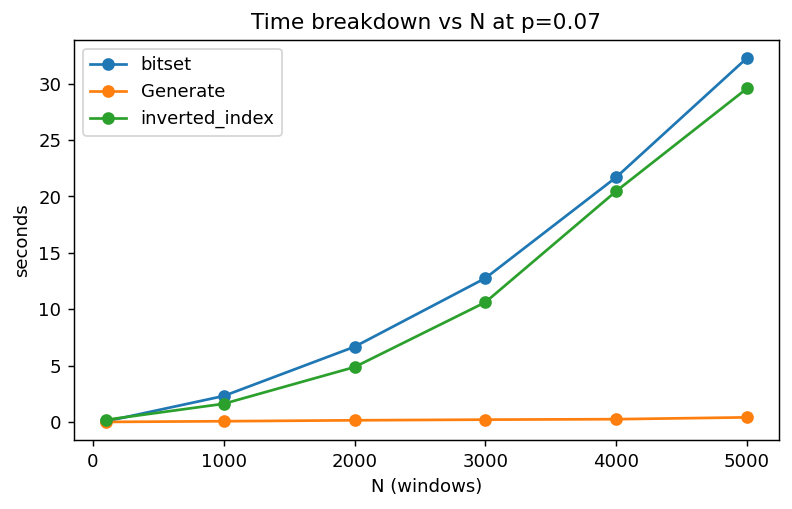

In [45]:
# Choose a p (or tweak to group by p for a fixed N)
p_choose = sorted(df["p"].unique())[-1]
sub = df[df["p"]==p_choose].copy()
sub = sub[(sub["method"].isin(["data","bitset","inverted_index"])) & (sub["step"].isin(["generate","compute"]))]

fig = plt.figure(figsize=(7,4))
for method, grp in sub.groupby("method"):
    g2 = grp.sort_values("N")
    label = "Generate" if method=="data" else method
    plt.plot(g2["N"], g2["time_sec"], marker="o", label=f"{label}")

plt.xlabel("N (windows)")
plt.ylabel("seconds")
plt.title(f"Time breakdown vs N at p={p_choose}")
plt.legend()
plt.show()


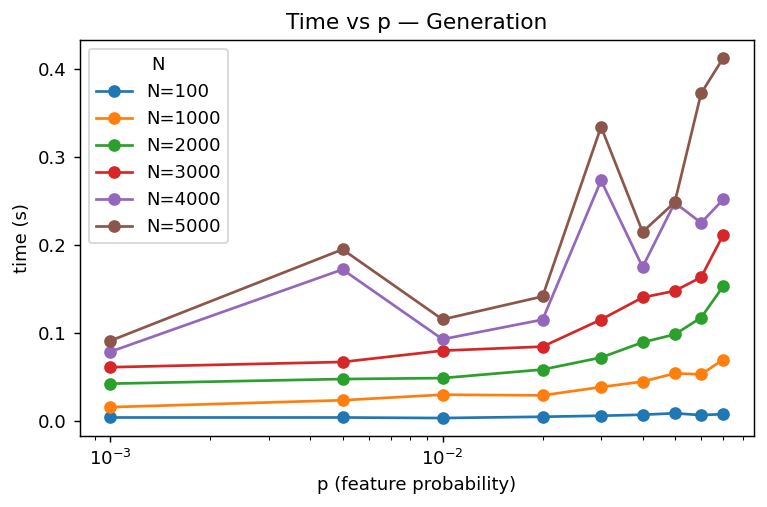

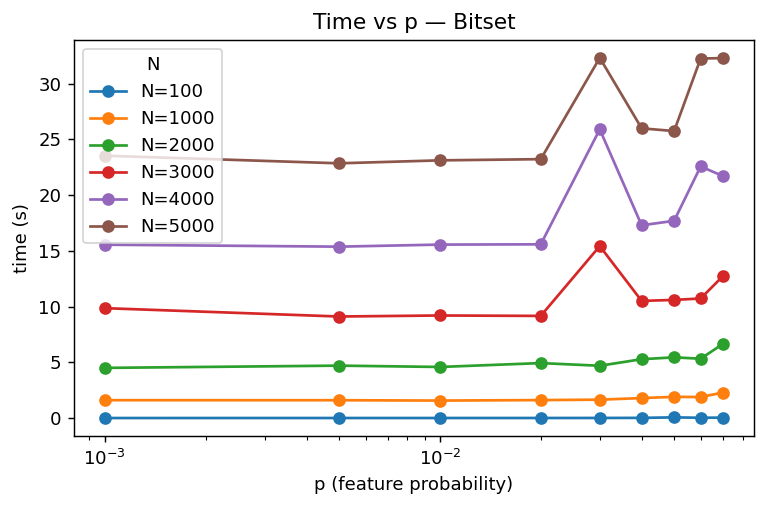

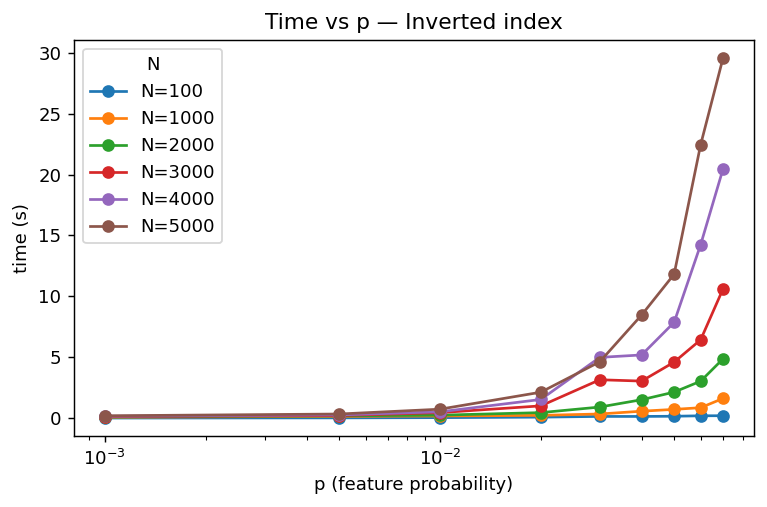

In [46]:
# Line plots: time vs p (separate curves for each N), one figure per method/step
def plot_time_vs_p(df, method, title=None, xlog=True, ylog=False):
    # pick the right step for each method
    step = "generate" if method == "data" else "compute"
    sub = df[(df["method"] == method) & (df["step"] == step)].copy()
    if sub.empty:
        print(f"No rows for method={method}.")
        return

    fig = plt.figure(figsize=(6,4))
    for N, grp in sub.groupby("N"):
        grp = grp.sort_values("p")
        plt.plot(grp["p"].values, grp["time_sec"].values, marker="o", label=f"N={N}")
    plt.xlabel("p (feature probability)")
    plt.ylabel("time (s)")
    if xlog: plt.xscale("log")
    if ylog: plt.yscale("log")
    if title is None:
        title = {"data":"Generation", "bitset":"Method 1: Bitset", "inverted_index":"Method 2: Inverted index"}[method]
    plt.title(f"Time vs p — {title}")
    plt.legend(title="N")
    plt.tight_layout()
    plt.show()

# One figure per method/step
plot_time_vs_p(df, method="data",             title="Generation")
plot_time_vs_p(df, method="bitset",           title="Bitset")
plot_time_vs_p(df, method="inverted_index",   title="Inverted index")


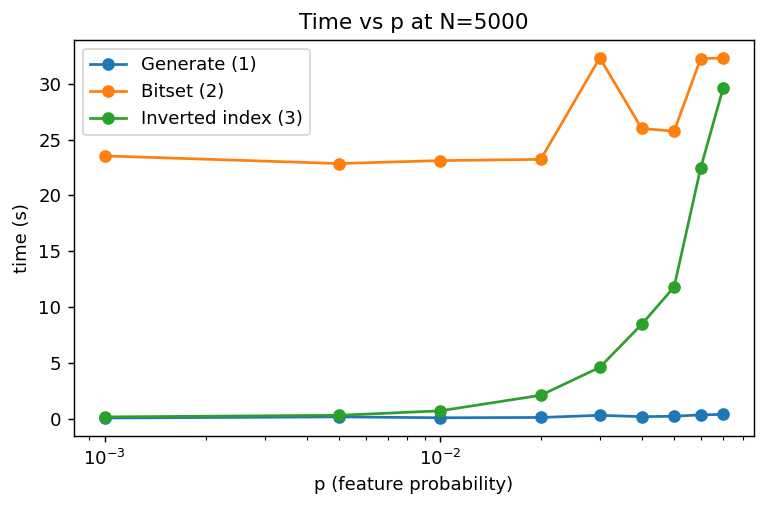

In [48]:
def plot_methods_vs_p_for_N(df, N_select, xlog=True, ylog=False):
    lines = [
        ("data", "generate",          "Generate (1)"),
        ("bitset", "compute",         "Bitset (2)"),
        ("inverted_index", "compute", "Inverted index (3)")
    ]
    fig = plt.figure(figsize=(6,4))
    have_any = False
    for method, step, label in lines:
        sub = df[(df["method"]==method) & (df["step"]==step) & (df["N"]==N_select)].sort_values("p")
        if sub.empty:
            continue
        plt.plot(sub["p"].values, sub["time_sec"].values, marker="o", label=label)
        have_any = True

    if not have_any:
        print(f"No data for N={N_select}")
        return
    if xlog: plt.xscale("log")
    if ylog: plt.yscale("log")
    plt.xlabel("p (feature probability)")
    plt.ylabel("time (s)")
    plt.title(f"Time vs p at N={N_select}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example: use your largest N from the sweep
plot_methods_vs_p_for_N(df, N_select=max(df["N"]))


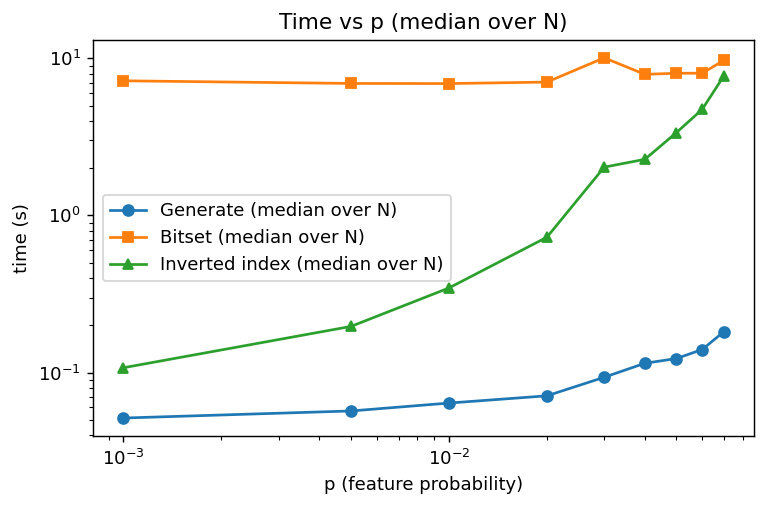

In [49]:
def plot_time_vs_p_median_over_N(df, xlog=True, ylog=True):
    fig = plt.figure(figsize=(6,4))
    styles = {
        ("data","generate"): "o-",
        ("bitset","compute"): "s-",
        ("inverted_index","compute"): "^-"
    }
    labels = {
        ("data","generate"): "Generate (median over N)",
        ("bitset","compute"): "Bitset (median over N)",
        ("inverted_index","compute"): "Inverted index (median over N)"
    }

    for (method, step), style in styles.items():
        sub = df[(df["method"]==method) & (df["step"]==step)]
        if sub.empty: 
            continue
        agg = sub.groupby("p", as_index=False)["time_sec"].median().sort_values("p")
        plt.plot(agg["p"].values, agg["time_sec"].values, style, label=labels[(method, step)])

    if xlog: plt.xscale("log")
    if ylog: plt.yscale("log")
    plt.xlabel("p (feature probability)")
    plt.ylabel("time (s)")
    plt.title("Time vs p (median over N)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_time_vs_p_median_over_N(df)
